In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPRegressor
import torch
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

In [3]:
def prepare_data(df):
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col] * df['AdjustmentFactor']
    
    df.ExpectedDividend.fillna(0, inplace=True)
    df.drop(['AdjustmentFactor', 'RowId'], axis=1, inplace=True)
    df['SupervisionFlag'] = df['SupervisionFlag'].astype(int)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.week
    df['Day'] = df['Date'].dt.day
    
    
    df.sort_values(by=['SecuritiesCode','Date'], inplace=True)
    df['Open'].interpolate(inplace=True)
    df['High'].interpolate(inplace=True)
    df['Low'].interpolate(inplace=True)
    df['Close'].interpolate(inplace=True)
    df.loc[df['Volume'] == 0,"Volume"] = np.nan
    df['Volume'].interpolate(inplace=True)
    df['Target'].interpolate(inplace=True)
    
    return df

def create_diffs(df):
    d1 = lambda df,col: df[col].diff(periods=1)/(df[col] + 1e-8)

    for f in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df['diff' + f] = d1(df, f)
    df['pctDailyChange'] = (df['Close'] - df['Open'])/df['Close']
    df = df.dropna()
    return df

In [4]:
t = pd.read_csv("../jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv",
                parse_dates=["Date"])
t = prepare_data(t)
t = create_diffs(t)

In [5]:
codes = t.SecuritiesCode.unique()
new_codes = dict(zip(codes, np.arange(2000)))
t = t.replace({'SecuritiesCode' : new_codes})

In [6]:
features = ['SecuritiesCode', 'Open', 'High', 'Low', 'Close'] 
target = 'Target'

In [16]:
train_df = t.loc[t.Date < t.Date.unique()[-100], [*features, target]]
test_df = t.loc[t.Date >= t.Date.unique()[-100], [*features, target]]
X_train = train_df[features].to_numpy()
y_train = train_df[target].to_numpy()
X_test = test_df[features].to_numpy()
y_test = test_df[target].to_numpy()

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [18]:
batchSize = 256
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)

In [19]:
class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        emb_size = 32
        self.layer1 = Linear(emb_size+n_inputs, 100)
        self.layer2 = Linear(100, 100)
        self.layer3 = Linear(100, 1)
        self.activation = LeakyReLU()
        #self.embedding = Embedding(2000, emb_size) 
        self.embedding = torch.rand([2000, emb_size], requires_grad=True).to(device)

 
    def forward(self, X):
        codes = X[:, 0].long()
        X = X[:, 1:]
        emb = self.embedding[codes]
        
        X = torch.cat((X, emb), 1)
        X = self.activation(self.layer1(X))
        X = self.activation(self.layer2(X))
        X = self.layer3(X)
        return X

In [20]:
model = MLP(len(features) - 1).to(device)

In [21]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, min_lr=1e-6, factor=0.5)

In [32]:
start_time = datetime.now()

for epoch in range(1):
    train_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            eval_loss = 0
            for i, (inputs, targets) in enumerate(test_dl):
                inputs, targets = inputs.to(device), targets.to(device)
                yhat = model(inputs)
                loss = criterion(yhat, targets)
                eval_loss += loss

        scheduler.step(eval_loss)

        #if epoch % 1 == 0:
        print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(test_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.0323, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0154, device='cuda:0')
0:00:23.894320


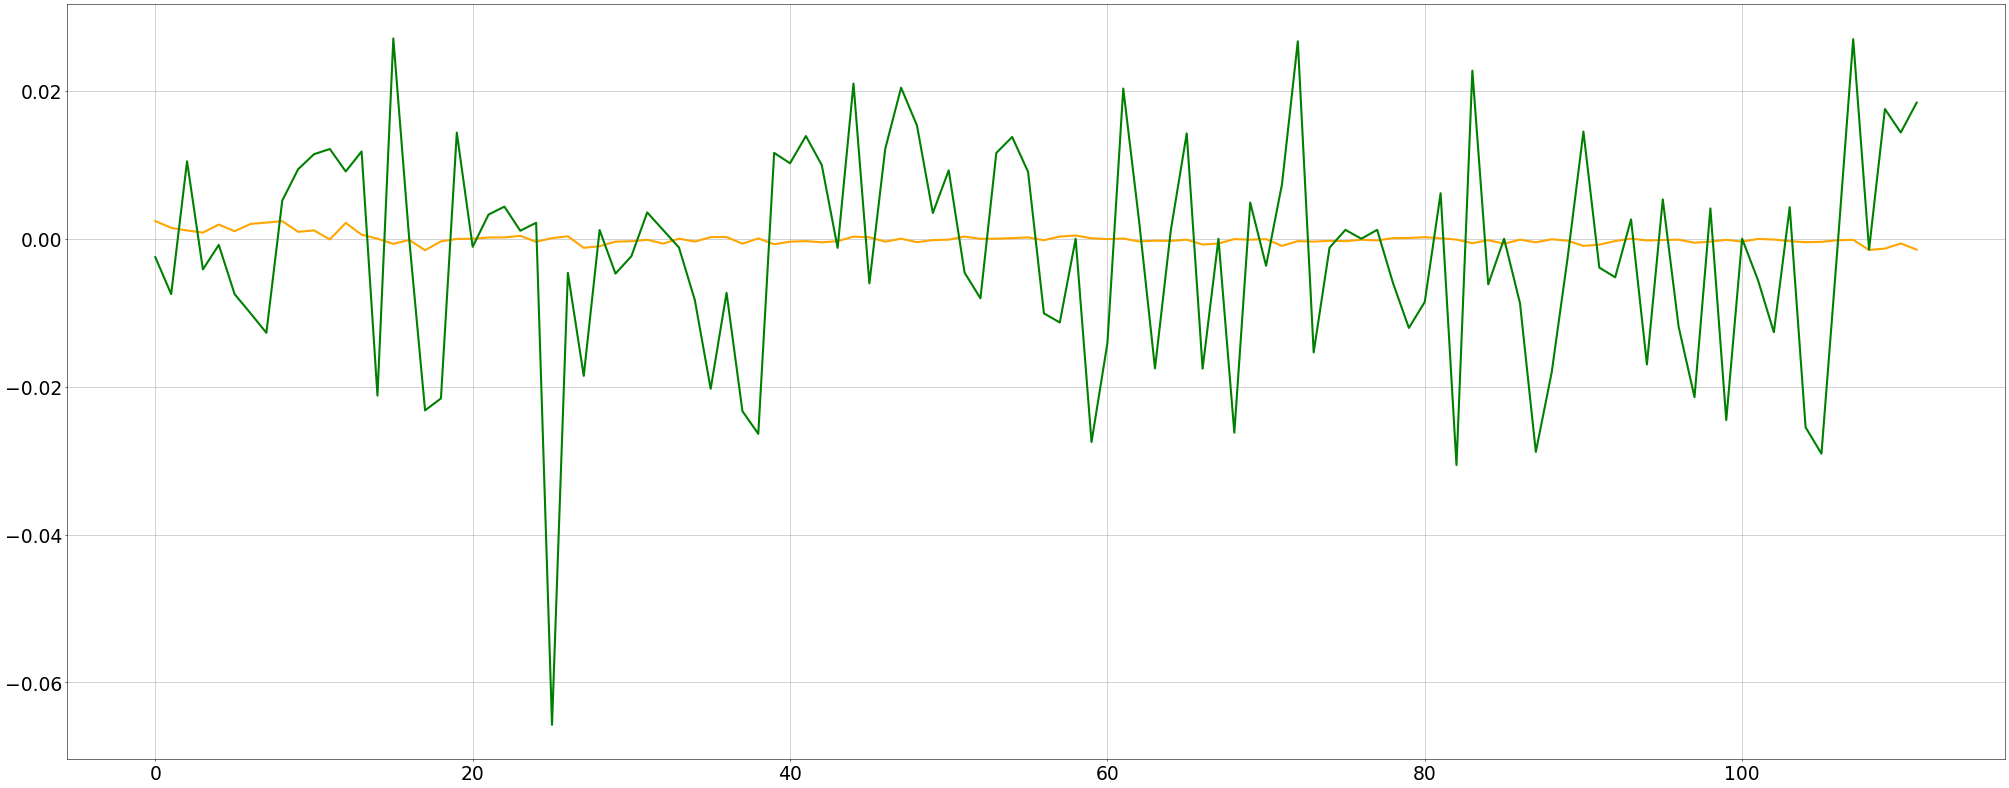

In [29]:
fig1, ax1 = plt.subplots(figsize=(50, 20), dpi=50)
ax1.tick_params(axis='y', which='both', labeltop='on', labelbottom='off', labelsize=27)
ax1.tick_params(axis='x', labelbottom='off', labelsize=27)
ax1.grid()
ax1.plot(yhat.cpu().detach().numpy(), lw=3, color='orange')
ax1.plot(targets.cpu().detach().numpy(), lw=3, color='green')

In [30]:
pricesSup = pd.read_csv('./supplemental_files/stock_prices.csv', parse_dates=["Date"])
pricesSup = prepare_data(pricesSup)
pricesSup = pricesSup.replace({'SecuritiesCode' : new_codes})
pricesSup = create_diffs(pricesSup)

In [31]:
with torch.no_grad():
    for date in pricesSup.Date.unique():
        x = torch.Tensor(pricesSup.loc[pricesSup.Date==date, [*features]].to_numpy()).to(device)
        pred = model(x)
        pricesSup.loc[pricesSup.Date==date, "Prediction"] = pred.cpu().detach().numpy()
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Prediction"].rank(ascending=False, method="first") - 1
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Rank"].astype("int")

sharpe_ratio, buf = calc_spread_return_sharpe(pricesSup)
sharpe_ratio

0.08132987093945732

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
     
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(score)

In [ ]:
with torch.no_grad():
    for date in pricesSup.Date.unique():
        x = pricesSup.loc[pricesSup.Date==date, [*features]].to_numpy()
        lgbm_pred = lgbm_model.predict(x)
        
        x = torch.Tensor(x).to(device)
        mlp_pred = model(x).cpu().detach().numpy().squeeze(1)
        
        pricesSup.loc[pricesSup.Date==date, "Prediction"] = mlp_pred*0.5 + 0.5*lgbm_pred
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Prediction"].rank(ascending=False, method="first") - 1
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Rank"].astype("int")
        
sharpe_ratio, buf = calc_spread_return_sharpe(pricesSup)
sharpe_ratio

In [ ]:
buf.std(), buf.mean()